# Evaluation

In [1002]:
from collections import defaultdict
import polars as pl

results_checkov = pl.read_json(f'results/checkov_1721775655.json')
results_tflint = pl.read_json(f'results/tflint_1721775655.json')

In [1003]:
CHECKOV_PATTERNS = [
    'Object storage lifecycle rules',
    'Old generation',
    'AWS - Expensive DynamoDB',
]

TFLINT_PATTERNS = [
    'Budget',
    'Object storage lifecycle rules',
    'Old generation',
    'AWS - Expensive DynamoDB',
]

## Precision/recall

### Checkov

#### Before

In [1004]:
checkov_clean = results_checkov.filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, url, before, _, _ in checkov_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in CHECKOV_PATTERNS:
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1

        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1

            print('----------')
            print('false positive:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', file['lines'], '-', file['path'])

        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

            print('----------')
            print('false positive:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', file['lines'], '-', file['path'])

----------
false positive: https://github.com/alphagov/govuk-aws/commit/6cfda6ada5137b232ff442ae9f2aedc8520ee1b4
commit: 7ec1573417fff41cae5b2081b007447e7a432789
real: Old generation
matched: ['Object storage lifecycle rules', 'Old generation']
Old generation - [195, 209] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-apt/main.tf
Old generation - [205, 219] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-deploy/main.tf
Old generation - [131, 145] - /home/koen/education/2023-2024/msc-thesis/repos/code/4-evaluation/snapshots/alphagov-govuk-aws-6cfda6ada5137b232ff442ae9f2aedc8520ee1b4/before-7ec1573417fff41cae5b2081b007447e7a432789/terraform/projects/app-logs-cdn/main.tf


In [1005]:
pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = checkov_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in CHECKOV_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern'))

shape: (3, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 3   ┆ 3   ┆ 24  ┆ 0   ┆ 0.111111  ┆ 1.0      │
│ Old generation                 ┆ 31  ┆ 16  ┆ 4   ┆ 15  ┆ 0.8       ┆ 0.516129 │
│ AWS - Expensive DynamoDB       ┆ 23  ┆ 23  ┆ 5   ┆ 0   ┆ 0.821429  ┆ 1.0      │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


#### Before + after

In [1006]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after, _ in checkov_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in CHECKOV_PATTERNS:
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

In [1007]:
pr = []
for pat in CHECKOV_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = checkov_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in CHECKOV_PATTERNS
])
pr_df = pl.DataFrame(pr)

summary = counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')

print(summary)

shape: (3, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Object storage lifecycle rules ┆ 3   ┆ 3   ┆ 48  ┆ 0   ┆ 0.058824  ┆ 1.0      │
│ Old generation                 ┆ 31  ┆ 16  ┆ 17  ┆ 15  ┆ 0.484848  ┆ 0.516129 │
│ AWS - Expensive DynamoDB       ┆ 23  ┆ 23  ┆ 20  ┆ 0   ┆ 0.534884  ┆ 1.0      │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


### TFLint

#### Before

In [1008]:
tflint_clean = results_tflint.filter([
        pl.col('before').list.len() != 0,
        pl.col('before').list.get(0).struct.field('errors').not_(),
        pl.col('after').struct.field('errors').not_(),
    ])

tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, url, before, _, _ in tflint_clean.iter_rows():
    matched_patterns = before[0]['matched']

    for pat in TFLINT_PATTERNS:
        if pat == real_pattern and pat in matched_patterns:
            tp[pat] += 1

        if pat != real_pattern and pat in matched_patterns:
            fp[pat] += 1

            print('----------')
            print('false positive:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', 'start:', file['start'], 'end:', file['end'], '-', file['path'])

        if pat == real_pattern and pat not in matched_patterns:
            fn[pat] += 1

            print('----------')
            print('false negative:', url)
            print('commit:', before[0]['id'])
            print('real:', real_pattern)
            print('matched:', matched_patterns)
            for file in before[0]['files']:
                print(file['pattern'], '-', 'start:', file['start'], 'end:', file['end'], '-', file['path'])

----------
false negative: https://github.com/nsbno/terraform-aws-cost-alarm/commit/7e135499d33f0a5c51602a506fefe258cac072c6
commit: a7890d10b370fb97fe57a18f7d1bfeedc49f99ae
real: Budget
matched: []
----------
false positive: https://github.com/64kramsystem/ultimate_aws_certified_cloud_practitioner_course_terraform_configuration/commit/2f36b8a5f2f818138da72d218c1f3c9666ed54aa
commit: 12b334b4a5eab43610932a844948d0eaba5267f3
real: Budget
matched: ['Old generation', 'Old generation', 'Old generation', 'Object storage lifecycle rules', 'Object storage lifecycle rules', 'Budget']
Old generation - start: {'line': 3, 'column': 3} end: {'line': 3, 'column': 29} - snapshots/64kramsystem-ultimate_aws_certified_cloud_practitioner_course_terraform_configuration-2f36b8a5f2f818138da72d218c1f3c9666ed54aa/before-12b334b4a5eab43610932a844948d0eaba5267f3/terraform/ec2_instances.london.tf
Old generation - start: {'line': 35, 'column': 3} end: {'line': 35, 'column': 29} - snapshots/64kramsystem-ultimate_

In [1009]:
pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = tflint_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in TFLINT_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(
    counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')
)

shape: (4, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Budget                         ┆ 15  ┆ 7   ┆ 15  ┆ 8   ┆ 0.318182  ┆ 0.466667 │
│ Object storage lifecycle rules ┆ 2   ┆ 2   ┆ 12  ┆ 0   ┆ 0.142857  ┆ 1.0      │
│ Old generation                 ┆ 10  ┆ 6   ┆ 3   ┆ 4   ┆ 0.666667  ┆ 0.6      │
│ AWS - Expensive DynamoDB       ┆ 14  ┆ 13  ┆ 0   ┆ 1   ┆ 1.0       ┆ 0.928571 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


#### Before + after

In [1010]:
tp = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

for real_pattern, _, before, after, _ in tflint_clean.iter_rows():
    matched_before = before[0]['matched']
    matched_after = after['matched']

    for pat in TFLINT_PATTERNS:
        if pat == real_pattern and pat in matched_before:
            tp[pat] += 1
        if pat != real_pattern and pat in matched_before:
            fp[pat] += 1
        if pat == real_pattern and pat not in matched_before:
            fn[pat] += 1

        if pat in matched_after:
            fp[pat] += 1

pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

In [1011]:
pr = []
for pat in TFLINT_PATTERNS:
    pr.append({
        'pattern': pat,
        'precision': tp[pat] / (tp[pat] + fp[pat]),
        'recall': tp[pat] / (tp[pat] + fn[pat]),
    })

counts_df = tflint_clean.group_by('pattern').len()
measures_df = pl.DataFrame([
    {
        'pattern': p,
        'tp': tp[p],
        'fp': fp[p],
        'fn': fn[p],
    }
    for p in TFLINT_PATTERNS
])
pr_df = pl.DataFrame(pr)

print(
    counts_df.join(measures_df, on='pattern').join(pr_df, on='pattern')
)

shape: (4, 7)
┌────────────────────────────────┬─────┬─────┬─────┬─────┬───────────┬──────────┐
│ pattern                        ┆ len ┆ tp  ┆ fp  ┆ fn  ┆ precision ┆ recall   │
│ ---                            ┆ --- ┆ --- ┆ --- ┆ --- ┆ ---       ┆ ---      │
│ str                            ┆ u32 ┆ i64 ┆ i64 ┆ i64 ┆ f64       ┆ f64      │
╞════════════════════════════════╪═════╪═════╪═════╪═════╪═══════════╪══════════╡
│ Budget                         ┆ 15  ┆ 7   ┆ 40  ┆ 8   ┆ 0.148936  ┆ 0.466667 │
│ Object storage lifecycle rules ┆ 2   ┆ 2   ┆ 24  ┆ 0   ┆ 0.076923  ┆ 1.0      │
│ Old generation                 ┆ 10  ┆ 6   ┆ 9   ┆ 4   ┆ 0.4       ┆ 0.6      │
│ AWS - Expensive DynamoDB       ┆ 14  ┆ 13  ┆ 3   ┆ 1   ┆ 0.8125    ┆ 0.928571 │
└────────────────────────────────┴─────┴─────┴─────┴─────┴───────────┴──────────┘


### Checkov + TFLint - Latest commits

In [1012]:
latest_matches = defaultdict(lambda: defaultdict(set))

for url, latest in checkov_clean.select('url', 'latest').filter(pl.col('latest').is_not_null()).iter_rows():
    for m in set(latest['matched']):
        prefix, *_ = url.split('/commit/')
        latest_matches[m]['checkov'].add(prefix)

for url, latest in tflint_clean.select('url', 'latest').filter(pl.col('latest').is_not_null()).iter_rows():
    for m in set(latest['matched']):
        prefix, *_ = url.split('/commit/')
        latest_matches[m]['tflint'].add(prefix)

print(pl.DataFrame([
    {
        'pattern': pat,
        'checkov': len(row['checkov']),
        'tflint': len(row['tflint']),
    }
    for pat, row in latest_matches.items()
]))

shape: (4, 3)
┌────────────────────────────────┬─────────┬────────┐
│ pattern                        ┆ checkov ┆ tflint │
│ ---                            ┆ ---     ┆ ---    │
│ str                            ┆ i64     ┆ i64    │
╞════════════════════════════════╪═════════╪════════╡
│ Object storage lifecycle rules ┆ 23      ┆ 18     │
│ Old generation                 ┆ 6       ┆ 6      │
│ AWS - Expensive DynamoDB       ┆ 11      ┆ 5      │
│ Budget                         ┆ 0       ┆ 31     │
└────────────────────────────────┴─────────┴────────┘


In [1013]:
from github import Github, Auth
from datetime import datetime, timedelta, UTC

with open('../1-coding/TOKEN.txt', 'r') as token_file:
    token = token_file.readline().strip()
    gh = Github(auth=Auth.Token(token))

print('Using GitHub as', gh.get_user().login)

latest_active_matches = defaultdict(lambda: defaultdict(set))

now = datetime.now(tz=UTC)
threshold = timedelta(days=183)

for pat, row in latest_matches.items():
    for tool, urls in row.items():
        for url in urls:
            try:
                repo = gh.get_repo(url[19:])
                if (now - repo.updated_at) <= threshold or (now - repo.pushed_at) <= threshold:
                    latest_active_matches[pat][tool].add(url)
            except Exception as e:
                print(e)

print(pl.DataFrame([
    {
        'pattern': pat,
        'checkov': len(row['checkov']),
        'tflint': len(row['tflint'])
    }
    for pat, row in latest_active_matches.items()
]))

Using GitHub as InputUsername


Following Github server redirection from /repos/circleci/enterprise-setup to /repositories/56541073
Following Github server redirection from /repos/dgorbov/terraform-s3-backend-setup to /repositories/230207730
Following Github server redirection from /repos/SamTowne/BasketballDrillBot to /repositories/369647866
Following Github server redirection from /repos/circleci/enterprise-setup to /repositories/56541073
Following Github server redirection from /repos/SamTowne/BasketballDrillBot to /repositories/369647866
Following Github server redirection from /repos/dgorbov/terraform-s3-backend-setup to /repositories/230207730
Following Github server redirection from /repos/circleci/enterprise-setup to /repositories/56541073
Following Github server redirection from /repos/circleci/enterprise-setup to /repositories/56541073
Following Github server redirection from /repos/SamTowne/BasketballDrillBot to /repositories/369647866
Following Github server redirection from /repos/dgorbov/terraform-s3-ba

shape: (4, 3)
┌────────────────────────────────┬─────────┬────────┐
│ pattern                        ┆ checkov ┆ tflint │
│ ---                            ┆ ---     ┆ ---    │
│ str                            ┆ i64     ┆ i64    │
╞════════════════════════════════╪═════════╪════════╡
│ Object storage lifecycle rules ┆ 10      ┆ 6      │
│ Old generation                 ┆ 2       ┆ 3      │
│ AWS - Expensive DynamoDB       ┆ 2       ┆ 0      │
│ Budget                         ┆ 0       ┆ 10     │
└────────────────────────────────┴─────────┴────────┘


### Checkov + TFLint - Rule match co-occurrences

In [1014]:
print(
    checkov_clean.select(
        'pattern',
        before=pl.col('before').list.get(0).struct.field('matched').list.len() > 1,
        after=pl.col('after').struct.field('matched').list.len() > 1,
    ).group_by('pattern').sum()
)

print(
    tflint_clean.select(
        'pattern',
        before=pl.col('before').list.get(0).struct.field('matched').list.len() > 1,
        after=pl.col('after').struct.field('matched').list.len() > 1,
    ).group_by('pattern').sum()
)

shape: (3, 3)
┌────────────────────────────────┬────────┬───────┐
│ pattern                        ┆ before ┆ after │
│ ---                            ┆ ---    ┆ ---   │
│ str                            ┆ u32    ┆ u32   │
╞════════════════════════════════╪════════╪═══════╡
│ AWS - Expensive DynamoDB       ┆ 15     ┆ 7     │
│ Old generation                 ┆ 8      ┆ 6     │
│ Object storage lifecycle rules ┆ 0      ┆ 0     │
└────────────────────────────────┴────────┴───────┘
shape: (4, 3)
┌────────────────────────────────┬────────┬───────┐
│ pattern                        ┆ before ┆ after │
│ ---                            ┆ ---    ┆ ---   │
│ str                            ┆ u32    ┆ u32   │
╞════════════════════════════════╪════════╪═══════╡
│ Budget                         ┆ 7      ┆ 7     │
│ Object storage lifecycle rules ┆ 2      ┆ 2     │
│ AWS - Expensive DynamoDB       ┆ 12     ┆ 11    │
│ Old generation                 ┆ 6      ┆ 6     │
└────────────────────────────────┴──

## Performance

### Summary

In [1015]:
with pl.Config(fmt_str_lengths=500, tbl_width_chars=500):
    print(
        results_checkov
            .select(
                'url',
                duration_before=pl.col('before').list.get(0).struct.field('duration'),
                duration_after=pl.col('after').struct.field('duration'),
            )
            .drop_nulls()
            .top_k(10, by=['duration_before', 'duration_after'])
    )

    print(
        results_tflint
            .select(
                'url',
                duration_before=pl.col('before').list.get(0).struct.field('duration'),
                duration_after=pl.col('after').struct.field('duration'),
            )
            .drop_nulls()
            .top_k(10, by=['duration_before', 'duration_after'])
    )

shape: (10, 3)
┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────┬────────────────┐
│ url                                                                                                              ┆ duration_before ┆ duration_after │
│ ---                                                                                                              ┆ ---             ┆ ---            │
│ str                                                                                                              ┆ f64             ┆ f64            │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════╪════════════════╡
│ https://github.com/ministryofjustice/cloud-platform-environments/commit/aa07f2d9772cc376589bec2cbb42f9ba849927db ┆ 406.844048      ┆ 513.153089     │
│ https://github.com/ministryofjustice/cloud-platform-environments/commit

In [1016]:
checkov_perf = {
    'before': results_checkov.select(duration=pl.col('before').list.get(0).struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    'after': results_checkov.select(duration=pl.col('after').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    # 'latest': results_checkov.select(duration=pl.col('latest').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
}

tflint_perf = {
    'before': results_tflint.select(duration=pl.col('before').list.get(0).struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    'after': results_tflint.select(duration=pl.col('after').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
    # 'latest': results_tflint.select(duration=pl.col('latest').struct.field('duration')).drop_nulls().get_column('duration').to_list(),
}

In [1017]:
print(
    'Checkov\n* before:\n    mean:',
    statistics.mean(checkov_perf['before']),
    '\n    median:',
    statistics.median(checkov_perf['before']),
    '\n* after:\n    mean:',
    statistics.mean(checkov_perf['after']),
    '\n    median:',
    statistics.median(checkov_perf['after']),
)

print(
    'TFLint\n* before:\n    mean:',
    statistics.mean(tflint_perf['before']),
    '\n    median:',
    statistics.median(tflint_perf['before']),
    '\n* after:\n    mean:',
    statistics.mean(tflint_perf['after']),
    '\n    median:',
    statistics.median(tflint_perf['after']),
)

Checkov
* before:
    mean: 29.367037892961402 
    median: 5.202333732042462 
* after:
    mean: 30.08861291259139 
    median: 5.286344248452224
TFLint
* before:
    mean: 0.4629013078556079 
    median: 0.09522906388156116 
* after:
    mean: 0.4658196696028527 
    median: 0.09273909707553685


### Plots

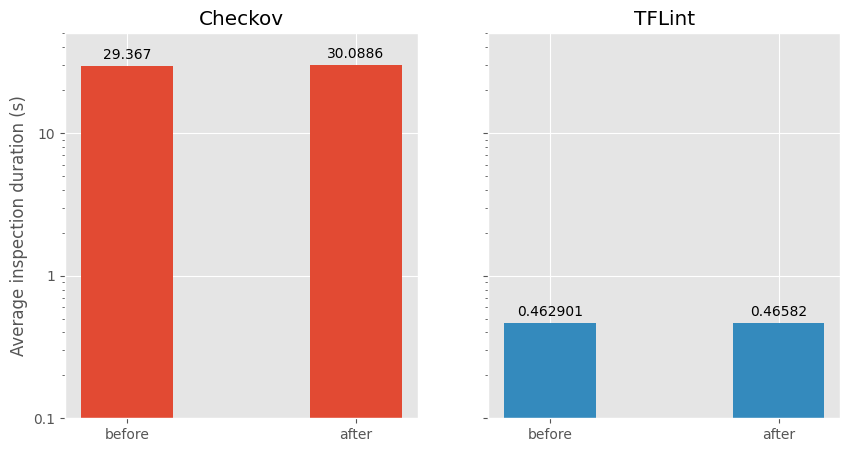

In [1018]:
import statistics
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

bar_data_checkov = [statistics.mean(v) for v in checkov_perf.values()]
bar_data_tflint = [statistics.mean(v) for v in tflint_perf.values()]

keys = list(checkov_perf.keys())
bar_width = 0.4
x1 = np.arange(len(checkov_perf))
x2 = np.arange(len(tflint_perf)) + len(checkov_perf) + bar_width

bars1 = ax1.bar(x1, bar_data_checkov, bar_width, label='Checkov')
ax1.bar_label(bars1, padding=3)
ax1.set_title('Checkov')
ax1.set_xticks(x1)
ax1.set_xticklabels(keys)
ax1.set_ylabel('Average inspection duration (s)')
ax1.set_yscale('log')
ax1.set_ylim(10**-1, 10**1.7)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

bars2 = ax2.bar(x2, bar_data_tflint, bar_width, label='TFLint', color='#348abd')
ax2.bar_label(bars2, padding=3)
ax2.set_title('TFLint')
ax2.set_xticks(x2)
ax2.set_xticklabels(keys)
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.show()

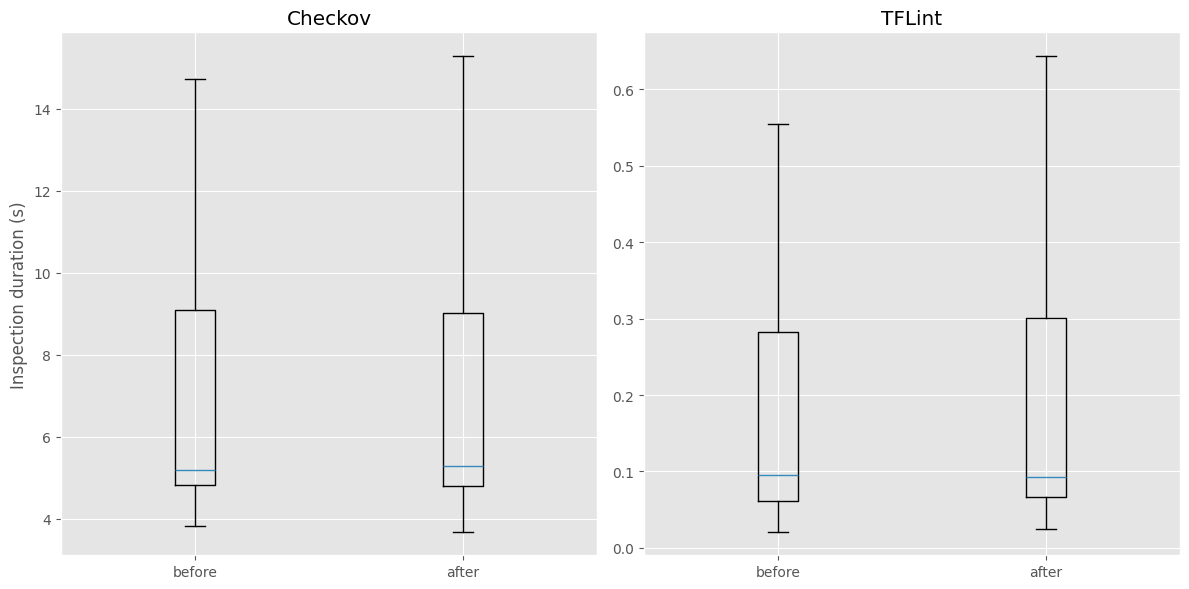

In [1019]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

keys = list(checkov_perf.keys())

ax1.boxplot(list(checkov_perf.values()), showfliers=False)
ax1.set_title('Checkov')
ax1.set_xticklabels(keys)
ax1.set_ylabel('Inspection duration (s)')

ax2.boxplot(list(tflint_perf.values()), showfliers=False)
ax2.set_title('TFLint')
ax2.set_xticklabels(keys)

plt.tight_layout()
plt.show()

In [1020]:
import os

def count_lines(root_dir: str) -> int:
    total = 0
    for base, _, files in os.walk(root_dir):
        for filename in files:
            if filename.endswith(('.tf', '.tf.json')):
                with open(os.path.join(base, filename), 'r') as f:
                    total += sum(1 for _ in f)
    return total

durations_checkov_before = []
lines_checkov_before = []

for url, before in results_checkov.select('url', 'before').iter_rows():
    if len(before) == 0:
        continue

    durations_checkov_before.append(before[0]['duration'])

    _, _, _, owner, repo, _, sha = url.split('/')

    snapshot_path = f'snapshots/{owner}-{repo}-{sha}'

    for version in os.listdir(snapshot_path):
        version_path = f'{snapshot_path}/{version}/'
        if version.startswith('before'):
            lines_checkov_before.append(count_lines(version_path))

durations_tflint_before = []
lines_tflint_before = []

for url, before in results_tflint.select('url', 'before').iter_rows():
    if len(before) == 0:
        continue

    durations_tflint_before.append(before[0]['duration'])

    _, _, _, owner, repo, _, sha = url.split('/')

    snapshot_path = f'snapshots/{owner}-{repo}-{sha}'

    for version in os.listdir(snapshot_path):
        version_path = f'{snapshot_path}/{version}/'
        if version.startswith('before'):
            lines_tflint_before.append(count_lines(version_path))

assert len(durations_checkov_before) == len(lines_checkov_before)
assert len(durations_tflint_before) == len(lines_tflint_before)

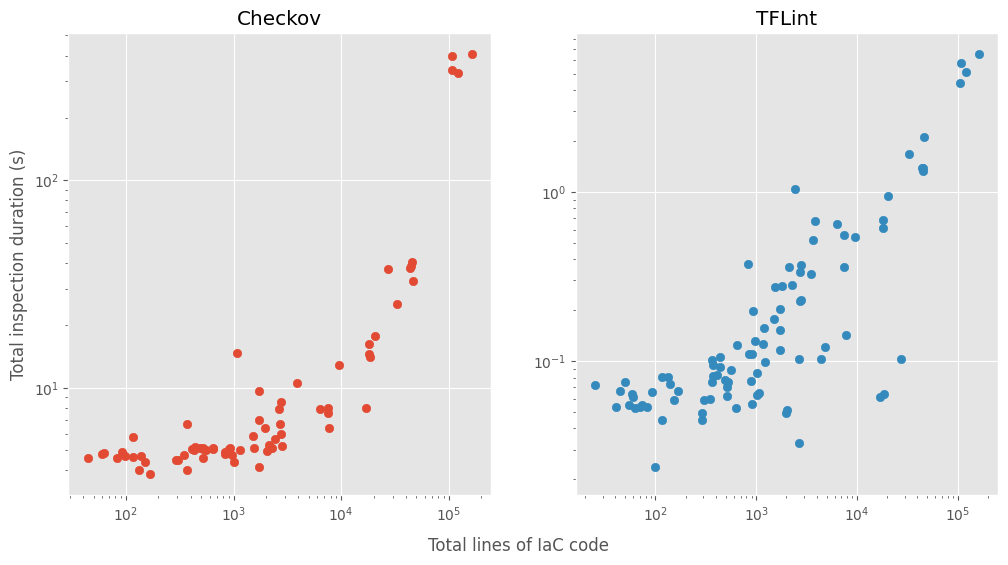

In [1021]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

ax1.scatter(y=durations_checkov_before, x=lines_checkov_before)
ax1.set_title('Checkov')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Total inspection duration (s)')

ax2.scatter(y=durations_tflint_before, x=lines_tflint_before, color='#348abd')
ax2.set_title('TFLint')
ax2.set_xscale('log')
ax2.set_yscale('log')

fig.supxlabel('Total lines of IaC code', color=ax1.yaxis.label.get_color())

plt.show()